**Objectifs du projet:**

Les données viennent du dataset SUIM Potsdam. Le but est de segmenter les images au niveau du pixel selon 5 classes: humain - récif - épave - robot - poisson. Nous considérons avoir 80% du jeu de données pour l'entraînement et 20% pour l'évaluation.

**Structure du dossier:**

train_val/ contient 1525 échantillons appariés pour l'entraînement/la validation
images/ : Images RVB de scènes sous-marines
masques/ : étiquettes de segmentation
Chaque couleur RGB représente une catégorie d'objet différente
TEST/ : 110 échantillons appariés pour l'évaluation de référence
images/ : Images de test RGB
masques/ : étiquettes des vérités de base
Des masques RVB combinés sont fournis
Les masques binaires individuels sont également fournis dans des dossiers séparés.


In [2]:
from google.colab import auth
auth.authenticate_user()


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

ModuleNotFoundError: No module named 'google'

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from glob import glob
import os
import cv2
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import fnmatch
import itertools as it
from __future__ import print_function

In [6]:
path = '/content/gdrive/MyDrive/segmentation sous marine'

In [7]:
# On définit la fonction load data qui prend en arguement le chemin vers les données et renvoie 4 listes avec les chemins triés des images originales de test et d'entrainement ainsi que les masques de tests et d'entrainements.
def load_data(path):

  """
  retourne 4 listes contenant chacune des chemins triés vers les images originales ou les masques pour l'entrainement et le test.
  args :
    path : Chemin vers les données.
  return : 
    listes de chemins
  """

  X_train = sorted(glob(os.path.join(path, "train_val", "train_val","images", "*jpg")))
  y_train = sorted(glob(os.path.join(path, "train_val","train_val", "masks", "*bmp")))

  X_test = sorted(glob(os.path.join(path, "TEST","TEST", "images", "*jpg")))
  y_test = sorted(glob(os.path.join(path, "TEST","TEST", "masks", "*bmp")))
  return X_train, y_train, X_test, y_test

In [8]:
"""RGB color code and object categories:
------------------------------------
000 BW: Background waterbody
001 HD: Human divers
010 PF: Plants/sea-grass
011 WR: Wrecks/ruins
100 RO: Robots/instruments
101 RI: Reefs and invertebrates
110 FV: Fish and vertebrates
111 SR: Sand/sea-floor (& rocks)"""

def getRobotFishHumanReefWrecks(mask):
    # for categories: HD, RO, FV, WR, RI
  imw, imh = mask.shape[0], mask.shape[1]
  Human = np.zeros((imw, imh))
  Robot = np.zeros((imw, imh))
  Fish = np.zeros((imw, imh))
  Reef = np.zeros((imw, imh))
  Wreck = np.zeros((imw, imh))
  for i in range(imw):
 
    for j in range(imh):
        if (mask[i,j,0]==0 and mask[i,j,1]==0 and mask[i,j,2]==1):
            Human[i, j] = 1 
        elif (mask[i,j,0]==1 and mask[i,j,1]==0 and mask[i,j,2]==0):
            Robot[i, j] = 1
        elif (mask[i,j,0]==1 and mask[i,j,1]==1 and mask[i,j,2]==0):
            Fish[i, j] = 1
        elif (mask[i,j,0]==1 and mask[i,j,1]==0 and mask[i,j,2]==1):
            Reef[i, j] = 1
        elif (mask[i,j,0]==0 and mask[i,j,1]==1 and mask[i,j,2]==1):
            Wreck[i, j] = 1
        else: pass
  return np.stack((Robot, Fish, Human, Reef, Wreck), -1)


In [9]:
def getRobotFishHumanWrecks(mask):
  # for categories: HD, RO, FV, WR
  imw, imh = mask.shape[0], mask.shape[1]
  Human = np.zeros((imw, imh))
  Robot = np.zeros((imw, imh))
  Fish = np.zeros((imw, imh))
  Wreck = np.zeros((imw, imh))
  for i in range(imw):

    for j in range(imh):
      if (mask[i,j,0]==0 and mask[i,j,1]==0 and mask[i,j,2]==1):
          Human[i, j] = 1 
      elif (mask[i,j,0]==1 and mask[i,j,1]==0 and mask[i,j,2]==0):
          Robot[i, j] = 1
      elif (mask[i,j,0]==1 and mask[i,j,1]==1 and mask[i,j,2]==0):
          Fish[i, j] = 1
      elif (mask[i,j,0]==0 and mask[i,j,1]==1 and mask[i,j,2]==1):
          Wreck[i, j] = 1
      else: pass
  return np.stack((Robot, Fish, Human, Wreck), -1)



In [10]:
def getSaliency(mask):
    # one combined category: HD/RO/FV/WR
  imw, imh = mask.shape[0], mask.shape[1]
  sal = np.zeros((imw, imh))
  for i in range(imw):
    for j in range(imh):
        if (mask[i,j,0]==0 and mask[i,j,1]==0 and mask[i,j,2]==1):
            sal[i, j] = 1 
        elif (mask[i,j,0]==1 and mask[i,j,1]==0 and mask[i,j,2]==0):
            sal[i, j] = 1
        elif (mask[i,j,0]==1 and mask[i,j,1]==1 and mask[i,j,2]==0):
            sal[i, j] = 1
        elif (mask[i,j,0]==0 and mask[i,j,1]==1 and mask[i,j,2]==1):
            sal[i, j] = 0.8
        else: pass
  return np.expand_dims(sal, axis=-1)


In [11]:
def processSUIMDataRFHW(img, mask, sal=False):
    # scaling image data and masks
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    m = []
    m.append(getRobotFishHumanReefWrecks(mask))
            #m.append(getRobotFishHumanWrecks(mask[i]))
    m = np.array(m)
    m = np.squeeze(m, axis=0)
    return (img, m)

In [12]:

# On définit cette classe qui permet d'importer les images et masques tout en appliquant quelques opérations dessus
class importData(Dataset):
  def __init__(self, images_path, masks_path): # Constructeur de la class importData

    self.images_path = images_path # Chemin des images
    self.masks_path = masks_path # Chemin des masques
    self.n_samples = len(images_path) # Nombre d'images

  def __getitem__(self, index):
    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)  # lecture de l'image
    mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
    #print("image_shape",image.shape)
    image = cv2.resize(image, (320, 240), interpolation = cv2.INTER_AREA) # On resize l'image
    #print("after resize image_shape",image.shape)
    #print(mask.shape)
    mask = cv2.resize(mask, (320, 240), interpolation = cv2.INTER_AREA)
    #print("after resize", mask.shape)
    image, mask = processSUIMDataRFHW(image, mask, False)
  
    image = np.transpose(image, (2, 0, 1))  # On change la position du chanel pour qu'on puisse utilise pytorch l'image en entrée avait le shape suivant : (320, 320, 3) en sortie : (3, 320, 320)
    image = image.astype(np.float32) # On convertit en type float

    image = torch.from_numpy(image) # On convertit on tenseur 

   
   
    mask = np.transpose(mask, (2, 0, 1))
    mask = mask.astype(np.float32) # On convertit en type float
    mask = torch.from_numpy(mask) # On convertit on tenseur 

    return image, mask # retourne l'image et masque correspondant 
  
  def __len__(self):
    return self.n_samples # retourne nombre d'images

In [13]:
def epoch_time(start_time, end_time):  # pour avoir la durée par epoch la fonction renvoie minutes et secondes écoulées par epoch
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [14]:
def seed_control(seed):  # Pour controler le caractère aléatoire et assurer la reproductibilité
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.deterministic = True

In [15]:
class Down(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, padding="same", kernel_size=(3,3))
    self.conv1_ = nn.Conv2d(64, 64, padding="same", kernel_size=(3,3))
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv2 = nn.Conv2d(64, 128, padding="same", kernel_size=(3,3))
    self.conv2_ = nn.Conv2d(128, 128, padding="same", kernel_size=(3,3))
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv3 = nn.Conv2d(128, 256, padding="same", kernel_size=(3,3))
    self.conv3_ = nn.Conv2d(256, 256, padding="same", kernel_size=(3,3))
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv4 = nn.Conv2d(256, 512, padding="same", kernel_size=(3,3))
    self.conv4_ = nn.Conv2d(512, 512, padding="same", kernel_size=(3,3))
    self.drop4 = nn.Dropout(p=0.5)
    self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv5 = nn.Conv2d(512, 1024, padding="same", kernel_size=(3,3))
    self.conv5_ = nn.Conv2d(1024, 1024, padding="same", kernel_size=(3,3))
    self.drop5 = nn.Dropout(p=0.5)
    self.relu = nn.ReLU()

  def forward(self, inputs):

    x = self.conv1(inputs)
    x = self.relu(x)
    x = self.conv1_(x)
    up1 = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.conv2_(x)
    up2 = self.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv3_(x)
    up3 = self.relu(x)
    x = self.pool3(x)

    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv4_(x)
    up4 = self.relu(x)
    drop_4 = self.drop4(x)
    
    x = self.pool4(drop_4)

    x = self.conv5(x)
    x = self.relu(x)
    x = self.conv5_(x)
    x = self.relu(x)
    drop_5 = self.drop5(x)

    return up1, up2, up3, drop_4, drop_5

In [16]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.down = Down()
    self.up_1 = nn.Upsample(scale_factor=2)
    self.conv1 = nn.Conv2d(1024, 512, padding="same", kernel_size=(2,2))
    self.conv1_ = nn.Conv2d(2*512, 512, padding="same", kernel_size=(3,3))
    self.conv1__ = nn.Conv2d(512, 512, padding="same", kernel_size=(3,3))

    self.up_2 = nn.Upsample(scale_factor=2)
    self.conv2 = nn.Conv2d(512, 256, padding="same", kernel_size=(2,2))
    self.conv2_ = nn.Conv2d(2*256, 256, padding="same", kernel_size=(3,3))
    self.conv2__ = nn.Conv2d(256, 256, padding="same", kernel_size=(3,3))

    self.up_3 = nn.Upsample(scale_factor=2)
    self.conv3 = nn.Conv2d(256, 128, padding="same", kernel_size=(2,2))
    self.conv3_ = nn.Conv2d(2*128, 128, padding="same", kernel_size=(3,3))
    self.conv3__ = nn.Conv2d(128, 128, padding="same", kernel_size=(3,3))

    self.up_4 = nn.Upsample(scale_factor=2)
    self.conv4 = nn.Conv2d(128, 64, padding="same", kernel_size=(2,2))
    self.conv4_ = nn.Conv2d(2*64, 64, padding="same", kernel_size=(3,3))
    self.conv4__ = nn.Conv2d(64, 64, padding="same", kernel_size=(3,3))

    self.conv5 = nn.Conv2d(64, 3, padding="same", kernel_size=(3,3))
    self.conv5_ = nn.Conv2d(3, 5, padding="same", kernel_size=(3,3))
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, inputs):

    down1, down2, down3, drop_4, drop_5 = self.down(inputs)
    
    x = self.up_1(drop_5)
    
    x = self.conv1(x)
    x = self.relu(x)
    
    merge1 = torch.cat([drop_4, x], axis=1)
    
    x = self.conv1_(merge1)
    x = self.relu(x)
    
    x = self.conv1__(x)
    x = self.relu(x)
    
    x = self.up_2(x)
    x = self.conv2(x)
    x = self.relu(x)
    merge2 = torch.cat([down3, x], axis=1)
    x = self.conv2_(merge2)
    x = self.relu(x)
    x = self.conv2__(x)
    x = self.relu(x)

    x = self.up_3(x)
    x = self.conv3(x)
    x = self.relu(x)
    merge3 = torch.cat([down2, x], axis=1)
    x = self.conv3_(merge3)
    x = self.relu(x)
    x = self.conv3__(x)
    x = self.relu(x)

    x = self.up_4(x)
    x = self.conv4(x)
    x = self.relu(x)
    merge4 = torch.cat([down1, x], axis=1)

    x = self.conv4_(merge4)
    x = self.relu(x)
    x = self.conv4__(x)
    x = self.relu(x)
    
    x = self.conv5(x)
    x = self.relu(x)
    x = self.conv5_(x)
    x = self.sigmoid(x)

    return x

In [17]:
seed_control(21) 
X_train, y_train, X_valid, y_valid = load_data(path) # Les chemins des données 

H = 320 # Height de l'image 
W = 240 # Width de l'image
size = (H, W)
batch_size = 10  
num_epochs = 25 # Nombre d'epochs
lr = 1e-4 # Learning rate

train_dataset = importData(X_train, y_train) # données d'entrainement
valid_dataset = importData(X_valid, y_valid) # données de test
# On load nos données d'entrainement
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
# On load nos données de test
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet() # Initialisation du modèle
model = model.to(device)

In [17]:
#loss
loss_fn = torch.nn.BCELoss()      #binary cross entropy 
#optimizer
optimizer = torch.optim.Adam(model.parameters()) 

In [18]:
def train(model, loader, optimizer, loss_fn, device): # Nous renvoie les loss tout en effectuant back propogation (calcul grads) et on updates les paramètres 
  epoch_loss = 0.0
  
  model.train()
  for x,y in loader: # on boocle sr les données
    x = x.to(device, dtype=torch.float32) # tenseur image originale
    y = y.to(device, dtype=torch.float32) # tenseur masque

    optimizer.zero_grad()
    out = model(x) # predictions des saliency maps
    
    loss = loss_fn(out, y) # calcul de la loss
    
    loss.backward() # back propagation
    optimizer.step() # on optimise la loss avec adam
    epoch_loss = epoch_loss + loss.item()
  
  epoch_loss = epoch_loss/len(loader) # on normalise


  return epoch_loss

In [19]:
def evaluate(model, loader, loss_fn, device):  # Nous renvoie les vals loss
  epoch_loss = 0.0
  model.eval()

  with torch.no_grad():
    for x,y in loader: # on boocle sur les données
      x = x.to(device, dtype=torch.float32) # tenseur image originale
      y = y.to(device, dtype=torch.float32) # tenseur masque
      out = model(x) # predictions des saliency maps
      loss = loss_fn(out, y) # calcul de la loss
      epoch_loss = epoch_loss + loss.item()

    epoch_loss = epoch_loss/len(loader)
    

  return epoch_loss

In [20]:
best_val_loss = np.inf # grande valeur 
checkpoint_path = '/content/gdrive/MyDrive/checkpoint.pth' # chemin des checkpoints

for epoch in range(num_epochs): # On boucle sur le nombre d'epochs
  start_time = time.time() # temps de début

  training_loss = train(model, train_loader, optimizer, loss_fn, device) # Calcul des loss et updates params
  valid_loss = evaluate(model, valid_loader, loss_fn, device) # calcul val loss

  end_time = time.time() # temps de fin
  epoch_mins, epoch_secs = epoch_time(start_time, end_time) # calcul des minutes et secondes de la durée de l'epoch

  data_str = f'Epoch : {epoch+1:02} / Epoch Time : {epoch_mins}m {epoch_secs}s'
  data_str += f'\t Train Loss : {training_loss:.3f} \n'
  data_str += f'\t Val Loss : {valid_loss:.3f} \n'

  # Saving the model

  if valid_loss < best_val_loss : # On enregistre un chzckpoint si la valid loss est meilleure que la précédente
    best_val_loss = valid_loss
    torch.save(model.state_dict(), checkpoint_path)
  data_str += f'\t Val Loss checkpoint: {best_val_loss:.3f}\n'
  
  print(data_str)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch : 01 / Epoch Time : 10m 59s	 Train Loss : 0.670 
	 Val Loss : 0.638 
	 Val Loss checkpoint: 0.638

Epoch : 02 / Epoch Time : 7m 52s	 Train Loss : 0.619 
	 Val Loss : 0.587 
	 Val Loss checkpoint: 0.587

Epoch : 03 / Epoch Time : 7m 51s	 Train Loss : 0.574 
	 Val Loss : 0.543 
	 Val Loss checkpoint: 0.543

Epoch : 04 / Epoch Time : 7m 51s	 Train Loss : 0.535 
	 Val Loss : 0.505 
	 Val Loss checkpoint: 0.505

Epoch : 05 / Epoch Time : 7m 50s	 Train Loss : 0.501 
	 Val Loss : 0.473 
	 Val Loss checkpoint: 0.473

Epoch : 06 / Epoch Time : 7m 54s	 Train Loss : 0.471 
	 Val Loss : 0.445 
	 Val Loss checkpoint: 0.445

Epoch : 07 / Epoch Time : 7m 51s	 Train Loss : 0.446 
	 Val Loss : 0.420 
	 Val Loss checkpoint: 0.420

Epoch : 08 / Epoch Time : 7m 53s	 Train Loss : 0.424 
	 Val Loss : 0.399 
	 Val Loss checkpoint: 0.399

Epoch : 09 / Epoch Time : 7m 50s	 Train Loss : 0.404 
	 Val Loss : 0.381 
	 Val Loss checkpoint: 0.381

Epoch : 10 / Epoch Time : 7m 50s	 Train Loss : 0.387 
	 Val Los

In [18]:
# On load le checkpoint 
checkpoint_path = '/content/gdrive/MyDrive/checkpoint.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_train = UNet() # Initialisation du modèle
model_train = model_train.to(device)
model_train.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [182]:
im_to_test = train_dataset[1][0]
mask_target = train_dataset[1][1]

In [183]:
x = np.expand_dims(im_to_test, axis=0)
x = x.astype(np.float32)
x = torch.from_numpy(x)
x = x.to(device)

In [184]:
with torch.no_grad():
  out = model_train(x)

In [185]:
out.size()

torch.Size([1, 5, 240, 320])

In [155]:
out = out[0].cpu().numpy()
#out>0.5
out=np.moveaxis(out, 0, -1)
out[out > 0.5] = 1
out[out <= 0.5] = 0
out.shape



(240, 320, 5)

In [168]:

y = mask_target.cpu().numpy()
y.shape

(5, 240, 320)

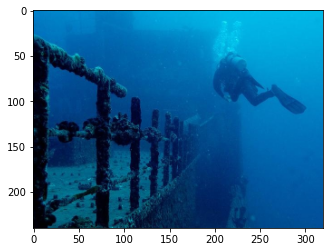

In [156]:
ori = im_to_test.cpu().numpy()
ori=np.moveaxis(ori, 0, -1)
im = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
plt.imshow(im)

plt.show()

(240, 320, 5)


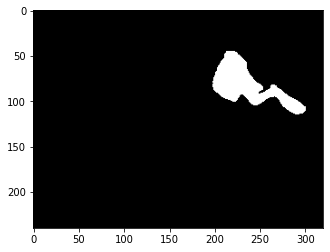

In [169]:
y=np.moveaxis(y, 0, -1)
print(y.shape)
im = y[:,:,0]
plt.imshow(im,cmap='gray')

plt.show()

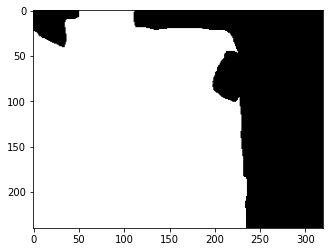

In [170]:
im = y[:,:,1]
plt.imshow(im,cmap='gray')

plt.show()

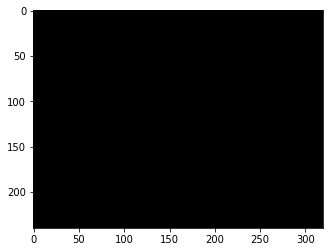

In [171]:
im = y[:,:,2]
plt.imshow(im,cmap='gray')

plt.show()

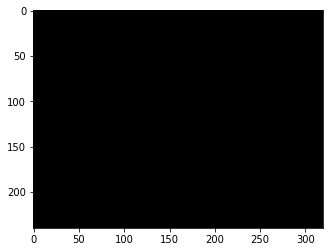

In [172]:
im = y[:,:,3]
plt.imshow(im,cmap='gray')

plt.show()

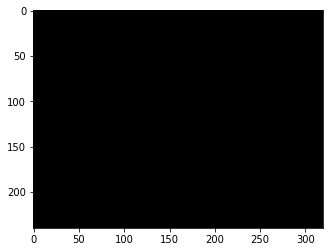

In [173]:
im = y[:,:,4]
plt.imshow(im,cmap='gray')

plt.show()

torch.Size([1, 5, 240, 320])


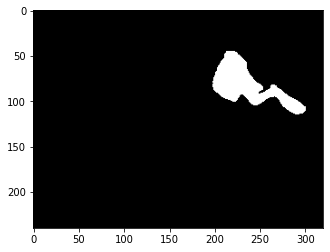

In [191]:
print(out.shape)
im = out[:,:,0]
plt.imshow(im,cmap='gray')

plt.show()

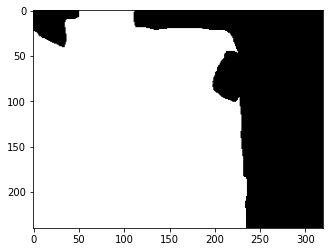

In [192]:
im = out[:,:,1]
plt.imshow(im,cmap='gray')

plt.show()

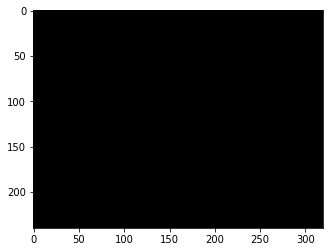

In [176]:
im = out[:,:,2]
plt.imshow(im,cmap='gray')

plt.show()

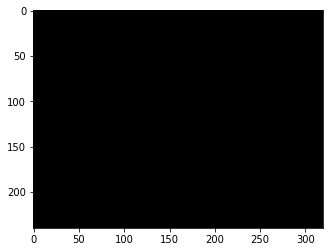

In [177]:
im = out[:,:,3]
plt.imshow(im,cmap='gray')

plt.show()

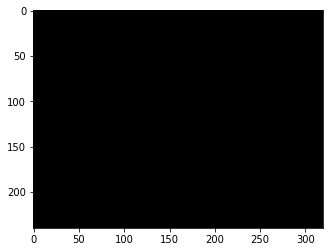

In [178]:
im = out[:,:,4]
plt.imshow(im,cmap='gray')

plt.show()

D'après les résultats obtenues, on peut conclure que le modèle a bien convergé et réalise la tache de segmentation.
Pour ameliorer ce modèle, on peut augmenter le nombre d'epoch ou également utiliser loss qui penalise plus l'erreur sur les pixels classés 1 plusqu'ils sont moins nombreux. 